In [223]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(suppress=True)

%matplotlib inline

In [171]:
files = glob.glob('./dat/*')

In [172]:
solo_vars = ['creepsPerMinDeltas', 'goldPerMinDeltas']
team_outcome = ['win']
time_deltas = ['0-10', '10-20', '20-30', '30-end']

dat_labels = []
print('labels:')
for v in solo_vars:
    for t in time_deltas:
        cur_label = v + '_' + t
        dat_labels.append(cur_label)
        print("('"+ cur_label + "', int),")
        
def get_winner(match):
    if match['teams'][0]['win'] == 'Win':
        return 0
    elif match['teams'][1]['win'] == 'Win':
        return 1
    else:
        return -1
    
def get_team_data(match_id, winner):
    team_dat = []

    team_vars = ['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald']

    for i in [(x+winner)%2 for x in range(2)]:
        for v in team_vars:
            cur_dat = match['teams'][i][v]*1
            team_dat.append(cur_dat)

    return np.array(team_dat)

def get_role_lane(match_id, participant_id):
    role = match['participants'][participant_id]['timeline']['role']
    lane = match['participants'][participant_id]['timeline']['lane']
    return [role, lane]

def get_participant_data(match_id, winner, debug=False):

    participant_data = []

    m = len(match['participants'][0]['timeline'][solo_vars[0]])
    
    participant_ids = [(x+winner*5) % 10 for x in range(10)]
    
    for participant_id in participant_ids:
        [role, lane] = get_role_lane(match_id, participant_id)
        cur_participant_data = []
        for v in solo_vars:
            for i, t in enumerate(time_deltas):
                if i + 1 <= m:
                    cur_participant_data.append(np.round(match['participants'][participant_id]['timeline'][v][t],2))
                else:
                    cur_participant_data.append(-1)
                
        cur_participant_data = np.array(cur_participant_data,
                                dtype = object)
        participant_data.append([role, lane, cur_participant_data])
    
    return np.array(participant_data)

def process_match(match_id):
    winner = get_winner(match_id)
    team_dat = get_team_data(match_id, winner)
    duration = match_id['gameDuration'] / 60
    duration_id = int(duration/10) # 0 if last 10-20, 1 if 20-30, 2 if 30-40, 3 if 40+, etc.
    participant_data = get_participant_data(match_id, winner)
    return winner, team_dat, duration, duration_id, participant_data

labels:
('creepsPerMinDeltas_0-10', int),
('creepsPerMinDeltas_10-20', int),
('creepsPerMinDeltas_20-30', int),
('creepsPerMinDeltas_30-end', int),
('goldPerMinDeltas_0-10', int),
('goldPerMinDeltas_10-20', int),
('goldPerMinDeltas_20-30', int),
('goldPerMinDeltas_30-end', int),


In [173]:
dat = []
for i, file in enumerate(files):

    with open(file, 'r') as fp:
        match = json.load(fp)
        try:
            cur_dat = process_match(match)
        except:
            print(i,file, 'broken')
            continue
        dat.append([file, np.array(cur_dat)])


50 ./dat/match_2807252465.json broken
69 ./dat/match_2808999355.json broken
131 ./dat/match_2812073616.json broken
140 ./dat/match_2812204847.json broken
149 ./dat/match_2814249792.json broken
182 ./dat/match_2819492699.json broken
200 ./dat/match_2820272221.json broken
201 ./dat/match_2820274123.json broken


In [174]:
dat = np.array(dat)

In [175]:
n = len(dat)
team_dat = []
durations = []
duration_ids = []
roles = []
lanes = []
creepgold = []
for i in range(n):
    team_dat.append(dat[i,1][1])
    durations.append(dat[i,1][2])
    duration_ids.append(dat[i,1][3])
    roles.append(dat[i,1][4][:,0])
    lanes.append(list(dat[i,1][4][:,1]))
    cur_creepgold_data = np.array([x.astype(float) for x in dat[i,1][4][:,2]])
    creepgold.append(cur_creepgold_data)
team_dat = np.array(team_dat)
durations = np.array(durations)
roles = np.array(roles)
lanes = np.array(lanes)
creepgold = np.array(creepgold)

In [176]:
roles.shape

(567, 10)

In [177]:
solotop = np.argwhere((roles == 'SOLO') & (lanes == 'TOP'))
solomid = np.argwhere((roles == 'SOLO') & (lanes == 'MIDDLE'))

In [178]:
solotop_games,solotop_counts = np.unique(solotop[:,0], return_counts=True)
solomid_games,solomid_counts = np.unique(solomid[:,0], return_counts=True)

In [179]:
# filter only those with 2+ solotop and solomid
valid_games = list(set(solotop_games[solotop_counts>1]).intersection(set(solomid_games[solomid_counts>1])))
n = len(valid_games)
print(n,'valid games')

258 valid games


In [180]:
team_dat = team_dat[valid_games]
durations = durations[valid_games]
roles = roles[valid_games]
lanes = lanes[valid_games]
creepgold = creepgold[valid_games]

In [181]:
solotop = np.argwhere((roles == 'SOLO') & (lanes == 'TOP'))
solomid = np.argwhere((roles == 'SOLO') & (lanes == 'MIDDLE'))

In [208]:
delta_solotop = []
delta_solomid = []
delta_rest_of_team = []
delta_all = []

for i in range(n):
    solotop_index_winner = solotop[2*i][1]
    solotop_index_loser = solotop[2*i+1][1]
    cur_delta_solotop = creepgold[i][solotop_index_winner] - creepgold[i][solotop_index_loser]
    delta_solotop.append(cur_delta_solotop)
    
    solomid_index_winner = solomid[2*i][1]
    solomid_index_loser = solomid[2*i+1][1]
    cur_delta_solomid = creepgold[i][solomid_index_winner] - creepgold[i][solomid_index_loser]
    delta_solomid.append(cur_delta_solomid)
    
    cur_delta_all = np.sum(creepgold[i][:5],axis=0) - np.sum(creepgold[i][5:],axis=0)
    
    cur_delta_rest_of_team = cur_delta_all - cur_delta_solotop - cur_delta_solomid
    
    delta_rest_of_team.append(cur_delta_rest_of_team)
    
    delta_all.append(cur_delta_all)
    
delta_solotop = np.array(delta_solotop)
delta_solomid = np.array(delta_solomid)
delta_rest_of_team = np.array(delta_rest_of_team)
delta_all = np.array(delta_all)

In [209]:
def remove_game_phase(array, phases_to_remove):
    return np.delete(array, np.array(phases_to_remove), axis=1)

In [210]:
phases_to_remove = [2,3,6,7] # keep only 0-20

delta_solotop_phases = remove_game_phase(delta_solotop, phases_to_remove)
delta_solomid_phases = remove_game_phase(delta_solomid, phases_to_remove)
delta_rest_of_team_phases = remove_game_phase(delta_rest_of_team, phases_to_remove)
delta_all_phases = remove_game_phase(delta_all, phases_to_remove)

(array([34., 47., 47., 43., 33., 31., 11.,  8.,  2.,  2.]),
 array([20.05 , 22.645, 25.24 , 27.835, 30.43 , 33.025, 35.62 , 38.215,
        40.81 , 43.405, 46.   ]),
 <a list of 10 Patch objects>)

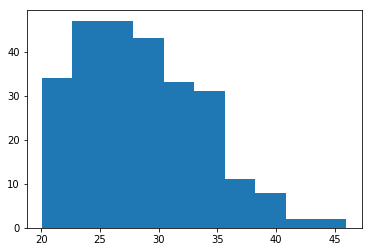

In [345]:
plt.hist(durations)

In [308]:
print(delta_solotop_phases.shape)
print(delta_solomid_phases.shape)
print(delta_rest_of_team_phases.shape)
print(delta_all_phases.shape)

(258, 4)
(258, 4)
(258, 4)
(258, 4)


In [333]:
delta = np.concatenate((delta_solotop_phases, delta_solomid_phases, delta_rest_of_team_phases),axis=1)
#delta = delta_all_phases

In [334]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(delta)
delta_rescaled = scaler.transform(delta)

In [335]:
X_winners = np.concatenate((team_dat[:,:6], delta_rescaled),axis=1)
X_losers = np.concatenate((team_dat[:,6:], -1*delta_rescaled),axis=1)

In [336]:
X = np.concatenate((X_winners, X_losers), axis=0)
X.shape

(516, 18)

In [337]:
from keras.utils import np_utils

Y = np.concatenate((np.ones(n), np.zeros(n))).reshape((2*n,1))
Y = np_utils.to_categorical(Y,2)
Y.shape

(516, 2)

In [338]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=0)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 412
number of test examples = 104
X_train shape: (412, 18)
Y_train shape: (412, 2)
X_test shape: (104, 18)
Y_test shape: (104, 2)


In [372]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras import optimizers


input_dim = X_train.shape[1]

model = Sequential()
#model.add(BatchNormalization())
model.add(Dense(12, input_dim=input_dim, activation='relu'))
#model.add(Dense(8, input_dim=input_dim, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(8, input_dim=12, activation='relu'))
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(lr=0.00001)

In [373]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 12)                228       
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 18        
Total params: 494
Trainable params: 494
Non-trainable params: 0
_________________________________________________________________


In [374]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#opt = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss = "binary_crossentropy", optimizer = opt)

In [375]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=1)

Epoch 1/30
412/412 [==============================] - 2s 4ms/step - loss: 0.7920 - acc: 0.5000
Epoch 2/30
412/412 [==============================] - 0s 58us/step - loss: 0.7915 - acc: 0.5000
Epoch 3/30
412/412 [==============================] - 0s 53us/step - loss: 0.7911 - acc: 0.5000
Epoch 4/30
412/412 [==============================] - 0s 56us/step - loss: 0.7907 - acc: 0.5000
Epoch 5/30
412/412 [==============================] - 0s 55us/step - loss: 0.7903 - acc: 0.5000
Epoch 6/30
412/412 [==============================] - 0s 55us/step - loss: 0.7900 - acc: 0.5000
Epoch 7/30
412/412 [==============================] - 0s 53us/step - loss: 0.7896 - acc: 0.5000
Epoch 8/30
412/412 [==============================] - 0s 54us/step - loss: 0.7892 - acc: 0.5000
Epoch 9/30
412/412 [==============================] - 0s 55us/step - loss: 0.7888 - acc: 0.5000
Epoch 10/30
412/412 [==============================] - 0s 54us/step - loss: 0.7884 - acc: 0.5000
Epoch 11/30
412/412 [===================

In [376]:
preds = model.evaluate(X_test,Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

104/104 [==============================] - 1s 5ms/step
Loss = 0.7671622863182654
Test Accuracy = 0.5096153846153846


In [344]:
df = pd.DataFrame(X_winners)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,1.0,1.0,0.0,1.0,1.0,-1.011295,-0.889438,-0.682714,0.257763,-0.739382,-0.988831,0.308106,0.962443,-0.638054,0.680111,1.280105,2.793156
1,0.0,1.0,0.0,1.0,1.0,1.0,1.614806,0.838270,2.015178,0.137802,-0.739382,0.710017,1.213217,1.348387,-0.484109,-0.911114,0.133219,0.688054
2,0.0,1.0,1.0,1.0,0.0,1.0,0.520597,-0.136335,-0.013312,0.566551,1.098127,-1.231523,1.031000,-1.274790,0.131668,0.426962,0.510783,1.007891
3,1.0,1.0,1.0,1.0,1.0,1.0,2.271332,0.705369,1.757813,-0.835955,-0.739382,0.224632,-1.175021,0.368384,0.798760,-0.079337,0.593108,0.772444
4,0.0,1.0,1.0,1.0,1.0,1.0,1.669517,0.306667,1.405363,0.693917,1.574518,0.224632,1.039961,-0.636468,-1.099887,-0.404815,1.274427,0.097748


In [245]:
categorical_cols = list(range(6))

In [284]:
df = pd.concat([df[categorical_cols].apply(lambda x: x.astype('category')), df.ix[:, 6:].astype('float')], axis=1)

/Users/ccl/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [285]:
df.describe(include = [np.number])

,7,8,9,10,11,12,13
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,1.564341,-0.028295,-0.089651,65.850388,326.486047,112.944574,75.778798
std,3.330307,2.781165,2.332240,174.700512,356.488602,297.939280,292.501901
min,-6.800000,-12.700000,-16.000000,-377.700000,-604.600000,-625.100000,-642.200000
25%,-0.200000,0.000000,0.000000,-53.300000,81.325000,0.000000,0.000000
50%,1.550000,0.000000,0.000000,47.050000,309.950000,0.000000,0.000000
75%,3.500000,0.000000,0.000000,176.775000,581.200000,64.075000,0.000000
max,9.200000,9.600000,10.400000,660.800000,1177.300000,1387.700000,1901.200000


In [286]:
df[list(range(6))].describe()

,0,1,2,3,4,5
count,258.0,258.0,258.0,258.0,258.0,258.0
unique,2.0,2.0,2.0,2.0,2.0,2.0
top,1.0,1.0,1.0,1.0,1.0,1.0
freq,137.0,163.0,219.0,168.0,178.0,137.0
